In [66]:
import yfinance as yf
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import math
import warnings
warnings.filterwarnings('ignore')

In [68]:
# Ticker for E-Mini S&P 500 Sep 2025 futures
trading_instrument = 'ES=F'
data = yf.download(trading_instrument, start="2000-09-18", end="2025-09-23", interval="1d", auto_adjust=False)
prices = data["Adj Close"]
prices = prices.loc[:,~prices.columns.duplicated()]
prices

[*********************100%***********************]  1 of 1 completed


Ticker            ES=F
Date                  
2000-09-18  1467.50000
2000-09-19  1478.50000
2000-09-20  1469.50000
2000-09-21  1469.50000
2000-09-22  1468.50000
...                ...
2025-09-16  6610.75000
2025-09-17  6601.25000
2025-09-18  6635.00000
2025-09-19  6658.77002
2025-09-22  6752.50000

[6316 rows x 1 columns]

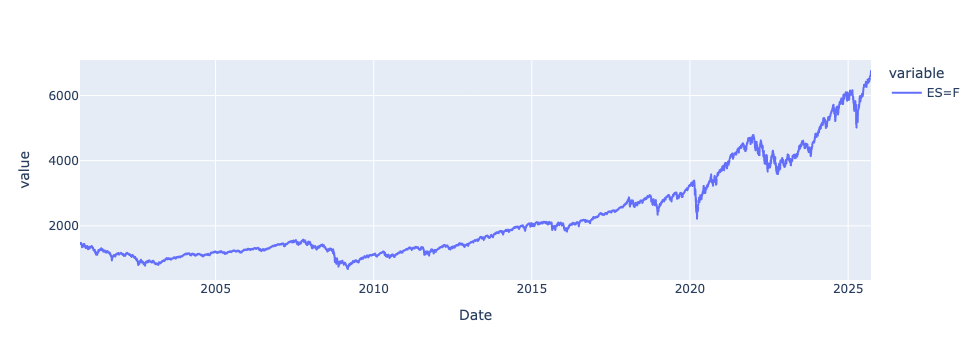

In [70]:
prices.columns.name = trading_instrument
px.line(prices['ES=F'])

## Data Engineering

In [72]:
def prepare_data_for_model_input(prices, ma):
    '''
        Input:
        prices (df) - Dataframe of close prices
        ma (int) - length of the moveing average

        Output:
        prices(df) - An enhanced prices dataframe, with moving averages and log return columns
        prices_array(nd.array) - an array of log returns
    '''
    instrument = prices.columns.name
    prices[f'{instrument}_ma'] = prices.rolling(ma).mean()
    prices[f'{instrument}_log_return'] = np.log(prices[f'{instrument}_ma']/prices[f'{instrument}_ma'].shift(1)).dropna()

    prices.dropna(inplace=True)
    prices_array = np.array([[q] for q in prices[f'{instrument}_log_return'].values])

    return prices, prices_array

In [74]:
prices, prices_array = prepare_data_for_model_input(prices, 7)
prices

ES=F              ES=F      ES=F_ma  ES=F_log_return
Date                                                
2000-09-27  1446.75000  1462.392857        -0.002025
2000-09-28  1476.00000  1462.035714        -0.000244
2000-09-29  1454.00000  1459.821429        -0.001516
2000-10-02  1456.25000  1457.928571        -0.001297
2000-10-03  1441.50000  1454.071429        -0.002649
...                ...          ...              ...
2025-09-16  6610.75000  6568.642857         0.002635
2025-09-17  6601.25000  6582.250000         0.002069
2025-09-18  6635.00000  6598.428571         0.002455
2025-09-19  6658.77002  6615.431431         0.002573
2025-09-22  6752.50000  6638.288574         0.003449

[6309 rows x 3 columns]

In [76]:
prices_array

array([[-0.00202496],
       [-0.00024425],
       [-0.00151567],
       ...,
       [ 0.00245489],
       [ 0.00257349],
       [ 0.00344917]])

# Regime Detection

## Modeling and in-sample testing

In [78]:
class RegimeDetection:
 
    def get_regimes_hmm(self, input_data, params):
        hmm_model = self.initialise_model(GaussianHMM(), params).fit(input_data)
        return hmm_model
    
    def get_regimes_clustering(self, params):
        clustering =  self.initialise_model(AgglomerativeClustering(), params)
        return clustering
    
    def get_regimes_gmm(self, input_data, params):
        gmm = self.initialise_model(GaussianMixture(), params).fit(input_data)
        return gmm
        
    def initialise_model(self, model, params):
        for parameter, value in params.items():
            setattr(model, parameter, value)
        return model

In [80]:
def plot_hidden_states(hidden_states, prices_df):
    
    '''
    Input:
    hidden_states(numpy.ndarray) - array of predicted hidden states
    prices_df(df) - dataframe of close prices
    
    Output:
    Graph showing hidden states and prices
    
    '''
    
    colors = ['blue', 'green']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()
 
    for i in range(n_components):
        mask = hidden_states == i
        print('Number of observations for State ', i,":", len(prices_df.index[mask]))
        
        fig.add_trace(go.Scatter(x=prices_df.index[mask], y=prices_df[f"{prices_df.columns.name}"][mask],
                    mode='markers',  name='Hidden State ' + str(i), marker=dict(size=4,color=colors[i])))
        
    fig.update_layout(height=400, width=900, legend=dict(
            yanchor="top", y=0.99, xanchor="left",x=0.01), margin=dict(l=20, r=20, t=20, b=20)).show()

In [82]:
regime_detection = RegimeDetection()

Number of observations for State  0 : 1578
Number of observations for State  1 : 4731


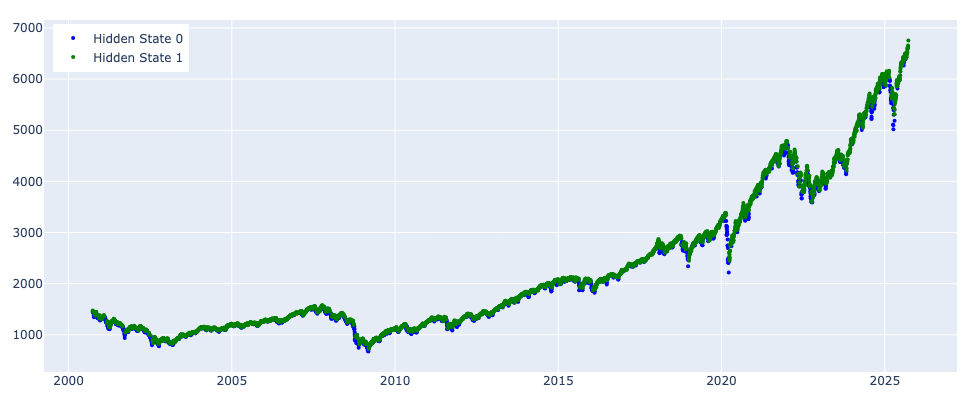

In [88]:
params = {'n_clusters': 2, 'linkage': 'complete',  'affinity': 'manhattan', 'metric': 'manhattan', 'random_state':100}
clustering = regime_detection.get_regimes_clustering(params)
clustering_states = clustering.fit_predict(prices_array)
 
plot_hidden_states(np.array(clustering_states), prices[[f'{trading_instrument}']])

Number of observations for State  0 : 5832
Number of observations for State  1 : 477


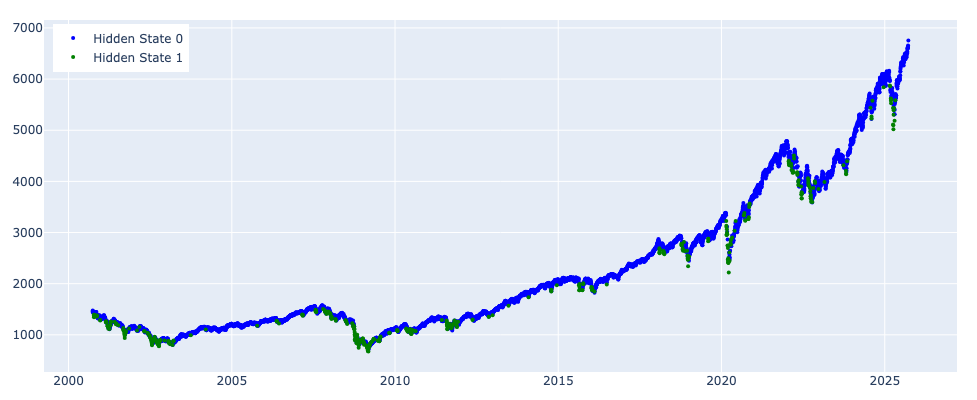

In [90]:
params = {'n_components':2, 'covariance_type': 'full', 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}
 
gmm_model = regime_detection.get_regimes_gmm(prices_array, params)
gmm_states = gmm_model.predict(prices_array)
plot_hidden_states(np.array(gmm_states), prices[[f'{trading_instrument}']])

Number of observations for State  0 : 846
Number of observations for State  1 : 5463


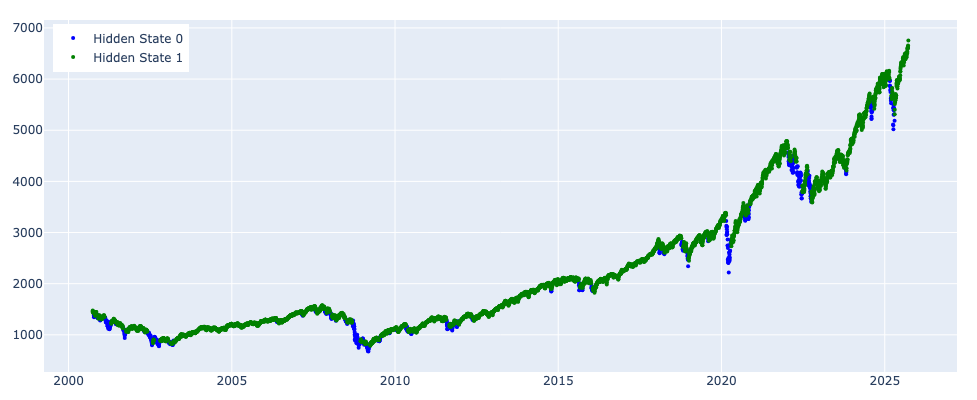

In [92]:
params = {'n_components':2, 'covariance_type':"full", 'random_state':100}
 
hmm_model = regime_detection.get_regimes_hmm(prices_array, params)
hmm_states = hmm_model.predict(prices_array)
plot_hidden_states(np.array(hmm_states), prices[[f'{trading_instrument}']])

## Feed-forward training and out of sample testing

In [97]:
def feed_forward_training(model, params, prices, split_index, retrain_step):
    '''
    Input:
    model (<class 'method'>) - either gmm (Gaussian Mixture Models) or hmm (Hidden Markov Model)
    params (dict) - dictionary of parameters for a model
    prices (df) - Dataframe of close prices
    split_index (str) - index to split initial traing dataset and out of sample testing set
    retrain_step (int) - number of observations after which we retrain the model
    
    Output:
    states_pred (numpy.ndarray) - array of predicted hidden states
    '''
    # train/test split and initial model training
    init_train_data = prices[:split_index]
    test_data = prices[split_index:]
    rd_model = model(init_train_data, params)
    
    # predict the state of the next observation
    states_pred = []
    for i in range(math.ceil(len(test_data))):
        split_index += 1
        preds = rd_model.predict(prices[:split_index]).tolist()
        states_pred.append(preds[-1])
        
        # retrain the existing model
        if i % retrain_step == 0:
            rd_model = model(prices[:split_index], params)
            
    return  states_pred

In [127]:
model_gmm =  regime_detection.get_regimes_gmm
params = {'n_components':2, 'covariance_type':"full", 'random_state':100, 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}
split_index = np.where(prices.index > '2006-01-01')[0][0]

Number of observations for State  0 : 3259
Number of observations for State  1 : 1709


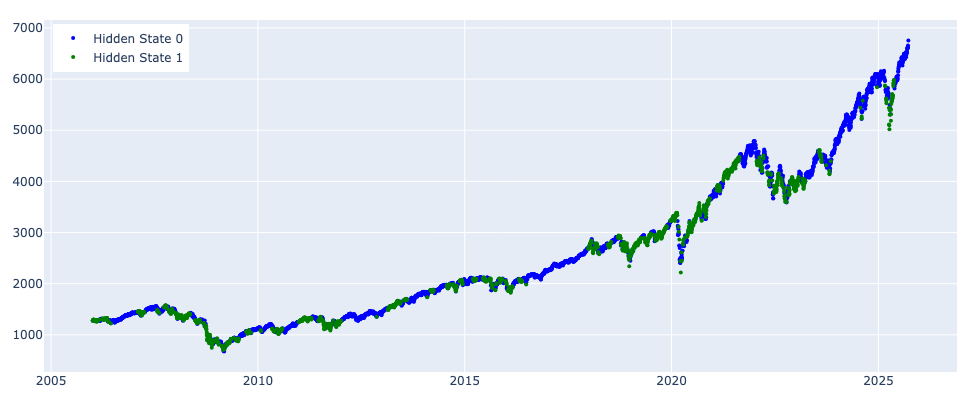

In [128]:
states_pred_gmm = feed_forward_training(model_gmm, params, prices_array, split_index, 20)
plot_hidden_states(np.array(states_pred_gmm), prices[[f'{trading_instrument}']][split_index:])

In [134]:
model_hmm =  regime_detection.get_regimes_hmm
params = {'n_components':2, 'covariance_type': 'full', 'random_state':100}

Number of observations for State  0 : 378
Number of observations for State  1 : 4590


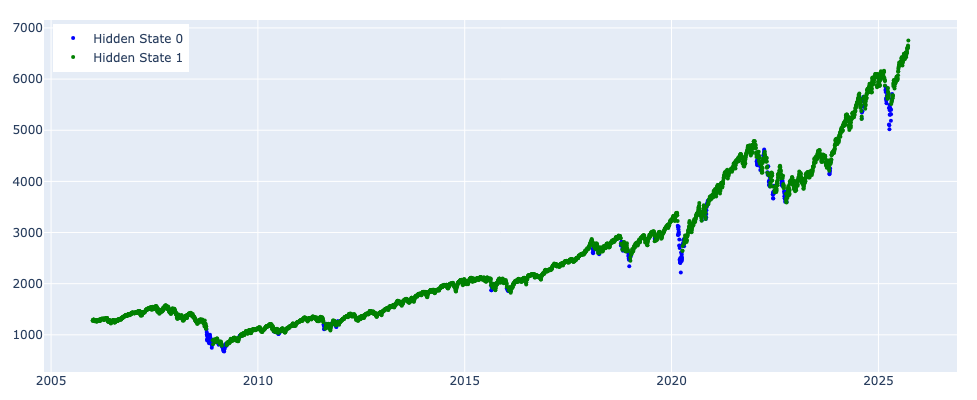

In [135]:
states_pred_hmm = feed_forward_training(model_hmm, params, prices_array, split_index, 20)
plot_hidden_states(np.array(states_pred_hmm), prices[[f'{trading_instrument}']][split_index:])

# Implementing an Investment Strategy

In [138]:
prices_with_states = pd.DataFrame(prices[split_index:][f'{trading_instrument}'])
prices_with_states['State'] = states_pred_hmm
prices_with_states.head()

ES=F  State
Date                      
2006-01-03  1274.75      1
2006-01-04  1280.50      1
2006-01-05  1281.25      1
2006-01-06  1291.75      1
2006-01-09  1295.00      1

In [140]:
prices_with_states['P&L_daily'] = np.log(prices_with_states['ES=F'] / prices_with_states['ES=F'].shift(1)).dropna()
prices_with_states.head()

ES=F  State  P&L_daily
Date                                 
2006-01-03  1274.75      1        NaN
2006-01-04  1280.50      1   0.004501
2006-01-05  1281.25      1   0.000586
2006-01-06  1291.75      1   0.008162
2006-01-09  1295.00      1   0.002513

In [142]:
prices_with_states['State'] = prices_with_states['State'].shift(1)
prices_with_states.dropna(inplace = True)

In [144]:
prices_with_states['Position'] = np.where(prices_with_states['State'] == 1,1,-1)
prices_with_states.head()

ES=F  State  P&L_daily  Position
Date                                           
2006-01-04  1280.50    1.0   0.004501         1
2006-01-05  1281.25    1.0   0.000586         1
2006-01-06  1291.75    1.0   0.008162         1
2006-01-09  1295.00    1.0   0.002513         1
2006-01-10  1296.00    1.0   0.000772         1

In [146]:
prices_with_states['Daily_Outcome_hmm'] = prices_with_states['Position'] * prices_with_states['P&L_daily']
prices_with_states['Cumulative_Outcome_BaH'] = prices_with_states['P&L_daily'].cumsum()
prices_with_states['Cumulative_Outcome_hmm'] = prices_with_states['Daily_Outcome_hmm'].cumsum()
prices_with_states

ES=F  State  P&L_daily  Position  Daily_Outcome_hmm  \
Date                                                                    
2006-01-04  1280.50000    1.0   0.004501         1           0.004501   
2006-01-05  1281.25000    1.0   0.000586         1           0.000586   
2006-01-06  1291.75000    1.0   0.008162         1           0.008162   
2006-01-09  1295.00000    1.0   0.002513         1           0.002513   
2006-01-10  1296.00000    1.0   0.000772         1           0.000772   
...                ...    ...        ...       ...                ...   
2025-09-16  6610.75000    1.0  -0.001625         1          -0.001625   
2025-09-17  6601.25000    1.0  -0.001438         1          -0.001438   
2025-09-18  6635.00000    1.0   0.005100         1           0.005100   
2025-09-19  6658.77002    1.0   0.003576         1           0.003576   
2025-09-22  6752.50000    1.0   0.013978         1           0.013978   

            Cumulative_Outcome_BaH  Cumulative_Outcome_hmm  
Date                                                        
2006-01-04                0.004501                0.004501  
2006-01-05                0.005086                0.005086  
2006-01-06                0.013248                0.013248  
2006-01-09                0.015761                0.015761  
2006-01-10                0.016533                0.016533  
...                            ...                     ...  
2025-09-16                1.645947                1.481723  
2025-09-17                1.644509                1.480285  
2025-09-18                1.649609                1.485384  
2025-09-19                1.653185                1.488961  
2025-09-22                1.667163                1.502939  

[4967 rows x 7 columns]

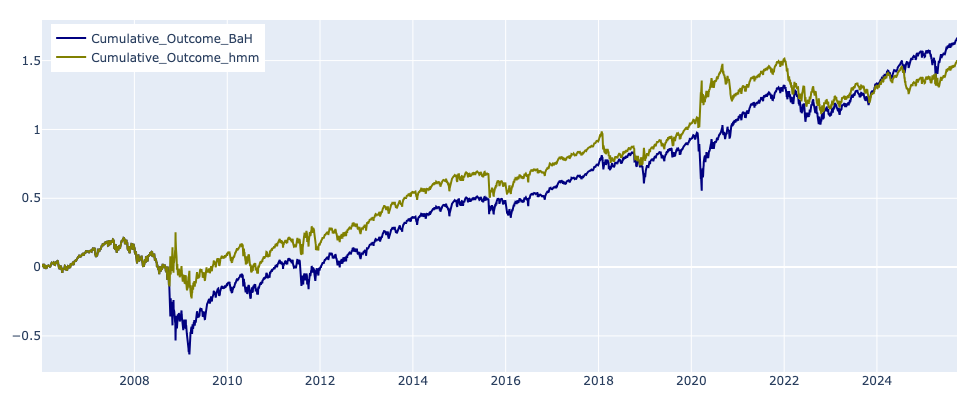

In [148]:
fig = go.Figure()
 
fig.add_trace(go.Line(x=prices_with_states.index, y=prices_with_states["Cumulative_Outcome_BaH"], 
                      name = 'Cumulative_Outcome_BaH', line_color = 'navy'))
 
fig.add_trace(go.Line(x= prices_with_states.index, y=prices_with_states['Cumulative_Outcome_hmm'], 
                      name = 'Cumulative_Outcome_hmm', line_color = 'olive'))
 
fig.update_layout(height=400, width=900, legend=dict(
    yanchor="top", y=0.99, xanchor="left",x=0.01), 
    margin=dict(l=20, r=20, t=20, b=20))
 
fig.show()